# Libraries and data import

In [1]:
from pySembrane.simulator import * 
from pySembrane.calculator import * 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# data = pd.read_csv('240219_Casestudy1_data_rev.csv', index_col=0)

In [2]:
import os
import win32com.client as win32
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pySembrane.simulator import * 
from pySembrane.calculator import * 

# Load Aspen Plus model

In [3]:
filename = 'Usage & examples/Casestudy/GreenNH3.apw'
sim = win32.Dispatch("Apwn.Document")
sim.InitFromArchive2(os.path.abspath(filename))
sim.Visible = True

MyBlocks = sim.Tree.Elements("Data").Elements("Blocks")
MyStreams = sim.Tree. Elements("Data").Elements("Streams")

ProcOut = MyStreams.Elements("402-2").Elements("Output")

# MOF data import

In [4]:
# isotherm 있는 membrane 만
mof_ads = pd.read_csv('Data/MOF_adsorptionHN.csv', index_col=0)
mof_mem = pd.read_csv('Data/MOF_membraneHN.csv', index_col=0)

mof_data = pd.merge(mof_ads, mof_mem, on='Adsorbent', how='left')

mof_data.columns

mof_data.fillna('NaN', inplace=True)
mof_noral = mof_data[mof_data['D_H2(m^2/s)'] != 'NaN']
mof_sort = mof_noral.sort_values(by='D_N2(m^2/s)')#[::100]

In [5]:
def MakeIsoFunc(func, par):
    def Lang(p, T):
        num = par[0]*par[1]*p
        den = 1+par[1]*p
        return num/den

    def Freu(p, T): # Freundlich isotherm model
        q = par[0]*p**par[1]
        return q

    ### With 3 parameters ###
    def Quad(p, T): # Quadratic isotherm model
        bP = par[1]*p
        dPP = par[2]*p**2
        deno = 1+ bP + dPP
        nume = par[0]*(bP + 2*dPP)
        q = nume/deno
        return q

    def Sips(p, T): # Sips isotherm model 
        n = par[2]
        numo = par[0]*par[1]*p**n
        deno = 1 + par[1]*p**n
        q = numo/deno
        return q
    
    def Pel(p, T): #Peleg
        q = par[0]*(p**par[1])+par[2]*(p**par[3])
        return q
    
    if func == 'Lang':
        isotherm = Lang
    elif func == 'Freu':
        isotherm = Freu
    elif func == 'Quad':
        isotherm = Quad
    elif func == 'Sips':
        isotherm = Sips
    elif func == 'Pel':
        isotherm = Pel

    return isotherm


def WhichIsoFunction_MOF(target):
    gases = ['H2', 'N2']
    iso_mix = []
    for gas in gases:
        col_name = [f'{gas} Isotherm_{i}' if i != 1 else f'{gas} Isotherm' for i in range(3,0,-1)]
        
        for col in col_name:
            if target[col] != 'NaN':
                idx = col[-1]
                if col == col_name[-1]:
                    par_ = target.loc[[f'qm_{gas}', f'b_{gas}']].values
                    func_ = target[col]
                    
                else:
                    par_str = target[f'par_{gas}_{idx}'][1:-1].split()
                    par_ = [float(par) for par in par_str]
                    func_ = target[col]
                iso_ = MakeIsoFunc(func_, par_)
                break
            else:
                continue
        iso_mix.append(iso_)
    return iso_mix


##### Permeance calculation with pressure ######
def CalculPermeance_P(P, isotherm, diff, rho, thickness):
    p_i = isotherm(P, T)*diff / P * rho # Permeability(mol mm2/(bar s mm3) )
    a_i = p_i/thickness               #Permeance(mol/(mm2 bar s)) = Permeability(mol mm2/(bar s mm3)) / mm    
    return a_i

In [6]:
### Module design ###
n_component = 2               # number of gas components
config = 'COFS'               # module configureation
L = 0.6*1e3                   # fiber length (mm)
D_module = 0.3*1e3            # Module diameter (mm)
N_fiber = 100                 # number of fiber (-)
N = 100                       # number of nodes (-)

### Membrane property ###
D_inner = 100*1e-1            # Membrane inner diameter (mm)
D_outer = 250*1e-1            # Membrane outer diameter (mm)

### Gas property ###
Mw_i = np.array([2e-3, 28e-3])                 # molar weight (kg/mol)
rho_i = np.array([0.08988, 1.1606])*1e-9       # density (kg/mm3)
mu_i = np.array([0.94e-3, 1.89e-3])            # viscosity (Pa s)

### Mass transfer property ###
k_mass = 1e-1              # Mass transfer coeff. (mm/s)

# Load Asepn results (Operating conditions)
P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
T = ProcOut.Elements("RES_TEMP").Value + 273.15
F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)

thickness = (D_outer-D_inner)/2

In [7]:
## Sensitivity analysis
comp_list = np.linspace(2, 15, 5)
H2_prod = []

for ii in range(0, len(mof_sort),int(len(mof_sort)/5)):

    target = mof_sort.iloc[ii,:]
    iso_list = WhichIsoFunction_MOF(target)
    diff_list = target[['D_H2(m^2/s)', 'D_N2(m^2/s)']]*1e6    # Self-diffusivity (mm2/s)
    rho = target['Density(kg ads/m^3)']*1e-9                # COF density (kg ads/mm3)
    
    for _comp in comp_list:

        compressor = MyBlocks.Elements("COMP-100").Elements("Input").Elements("PRES")
        compressor.Value = _comp

        sim.Run2()
        sim.Save()

        # Operating conditions
        P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
        T = ProcOut.Elements("RES_TEMP").Value + 273.15
        F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
        x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
        x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
        y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)
        Ff_z0_init = list(y_feed*F_feed)
        Pf = P_feed*y_feed

        a_cof = np.array([CalculPermeance_P(Pf[j], iso_list[j], diff_list[j], rho, thickness) for j in range(2)])       

        mem = MembraneProc(config, L, D_module, N_fiber, 
                n_component, n_node = N)
        mem.membrane_info(a_cof, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)

        mem.boundaryC_info(y_feed, P_feed, F_feed, T)
        mem.initialC_info()

        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()

        MemOut = MyStreams.Elements("MEMOUT").Elements("Input")
        MemOut.Elements("FLOW").Elements("MIXED").Elements("HYDRO-01").Value = res[-1,2]*60*60*1e-3
        MemOut.Elements("FLOW").Elements("MIXED").Elements("NITRO-01").Value = res[-1,3]*60*60*1e-3
        MemOut.Elements("TEMP").Elements("MIXED").Value = T-273.15
        MemOut.Elements("PRES").Elements("MIXED").Value = res[-1,-1]

        sim.Run2()
        sim.Save()

        PureH2 = MyStreams.Elements("PUREH2").ElementS("Output").ElementS("RES_MASSFLOW").Value
        H2_purity = MyStreams.Elements("PUREH2").ElementS("Output").Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
        H2_prod.append([F_feed, x_H2, x_N2, res[-1,0], res[-1,1], res[-1,2], res[-1,3], PureH2, H2_purity])
        print("Total H2 production: ", PureH2, "kg/hr")
        print("=========================================")

Simulation started
Simulation is completed without warning
Mass balance (error %):  5.6643001103836355e-14
Total H2 production:  12.8700979 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  13.3884761 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.8862019922402716e-14
Total H2 production:  13.6710489 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.8858131221285644e-14
Total H2 production:  13.8215461 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.8855675798340095e-14
Total H2 production:  13.914827 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  12.9293464 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  13.2188076 kg/hr
Simulation started
Simulation is com

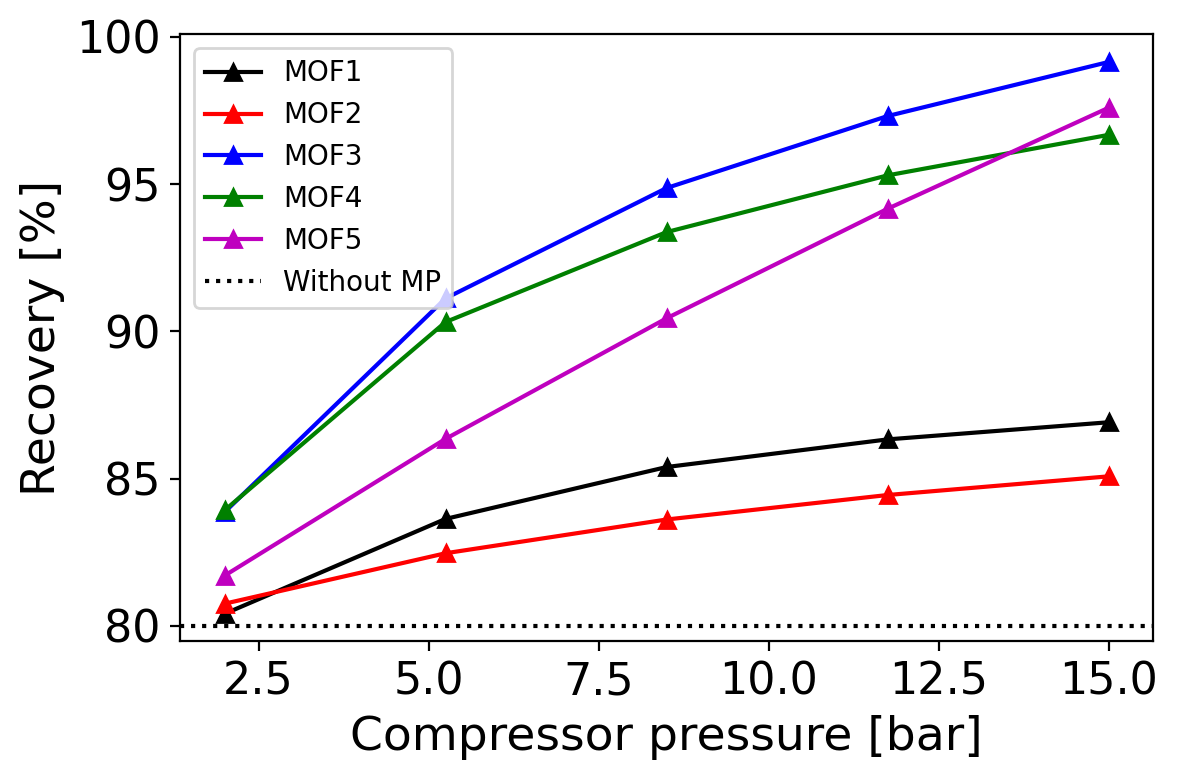

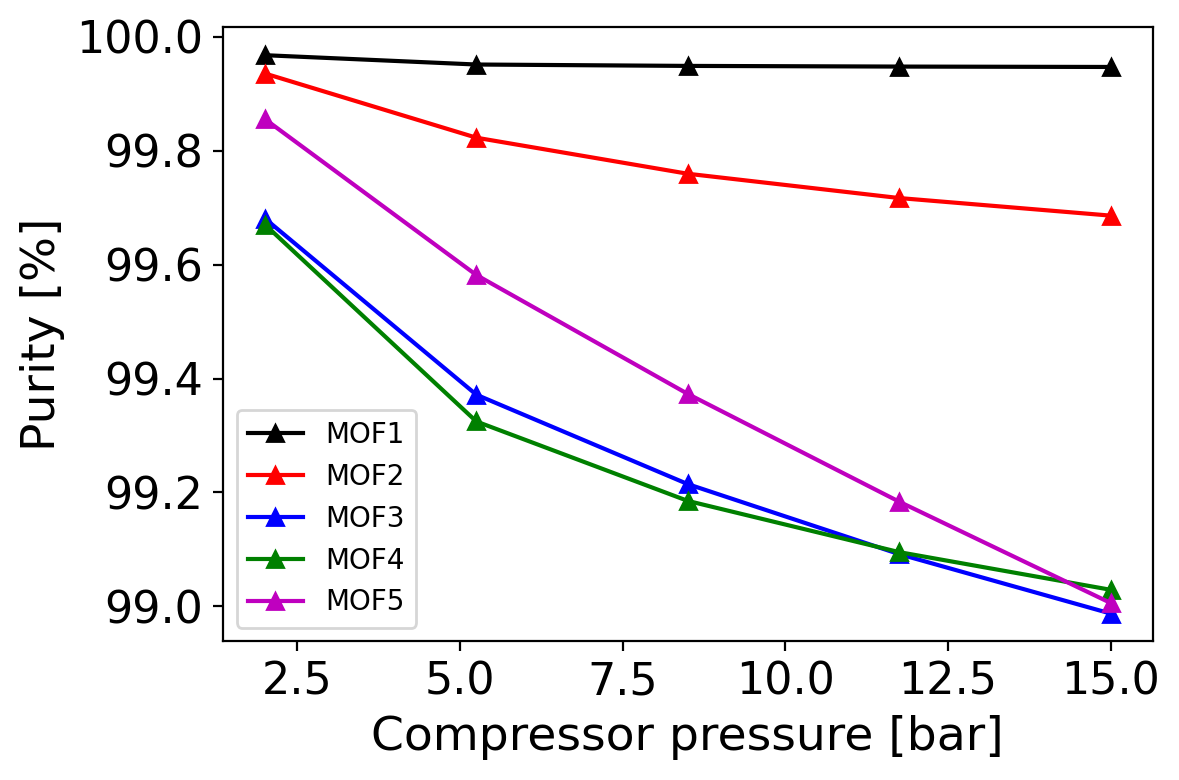

In [8]:
withoutMem = MyStreams.Elements("401").ElementS("Output").ElementS("RES_MASSFLOW").Value

c_list = ['k', 'r', 'b', 'g', 'm']
fig, ax1= plt.subplots(dpi=200, figsize=(6,4))
for ii in range(5):
    target = np.array(H2_prod[ii*len(comp_list):(ii+1)*len(comp_list)])
    ReH2 = target[:,-2]*target[:,-1]/16.0020554400001*100
    PuH2 = target[:,-1]*100

    line2 = ax1.plot(np.array(comp_list), ReH2, marker='^', c=c_list[ii],
            label=f'MOF{ii+1}', linestyle='-')
    
    ax1.set_ylabel('Recovery [%]')
ax1.set_xlabel('Compressor pressure [bar]')
plt.axhline(withoutMem/16.0020554400001*100, c='k', linestyle=':',
            label = 'Without MP')
plt.legend()
plt.tight_layout()
plt.show()

fig, ax1= plt.subplots(dpi=200, figsize=(6,4))
for ii in range(5):
    target = np.array(H2_prod[ii*len(comp_list):(ii+1)*len(comp_list)])
    PuH2 = target[:,-1]*100

    line2 = ax1.plot(np.array(comp_list), PuH2, marker='^', c=c_list[ii],
            label=f'MOF{ii+1}', linestyle='-')
    
    ax1.set_ylabel('Purity [%]')
ax1.set_xlabel('Compressor pressure [bar]')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
## 결과 저장
data_save = mof_sort.iloc[::int(len(mof_sort)/5),:].copy()

for ii, _comp in enumerate(comp_list):
    pp = _comp
    _names = ['Ff_in', 'x_H2', 'x_N2', 'Fr_H2', 'Fr_N2', 'Fp_H2', 'Fp_N2', 'H2_prod', 'H2_purity']
    col_name = [_name + f'_P({pp})' for _name in _names]
    
    data_save[col_name] = np.array(H2_prod[ii::5])

In [16]:
## Sensitivity analysis
ll_list = np.linspace(100, 1000, 5)
H2_prod = []

for ii in range(0, len(mof_sort),int(len(mof_sort)/5)):

    target = mof_sort.iloc[ii,:]
    iso_list = WhichIsoFunction_MOF(target)
    diff_list = target[['D_H2(m^2/s)', 'D_N2(m^2/s)']]*1e6    # Self-diffusivity (mm2/s)
    rho = target['Density(kg ads/m^3)']*1e-9                # COF density (kg ads/mm3)
    
    for _ll in ll_list:

        compressor = MyBlocks.Elements("COMP-100").Elements("Input").Elements("PRES")
        compressor.Value = 4

        sim.Run2()
        sim.Save()

        # Operating conditions
        P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
        T = ProcOut.Elements("RES_TEMP").Value + 273.15
        F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
        x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
        x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
        y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)
        Ff_z0_init = list(y_feed*F_feed)
        Pf = P_feed*y_feed

        a_cof = np.array([CalculPermeance_P(Pf[j], iso_list[j], diff_list[j], rho, thickness) for j in range(2)])       

        mem = MembraneProc(config, _ll, D_module, N_fiber, 
                n_component, n_node = N)
        mem.membrane_info(a_cof, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)

        mem.boundaryC_info(y_feed, P_feed, F_feed, T)
        mem.initialC_info()

        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()

        MemOut = MyStreams.Elements("MEMOUT").Elements("Input")
        MemOut.Elements("FLOW").Elements("MIXED").Elements("HYDRO-01").Value = res[-1,2]*60*60*1e-3
        MemOut.Elements("FLOW").Elements("MIXED").Elements("NITRO-01").Value = res[-1,3]*60*60*1e-3
        MemOut.Elements("TEMP").Elements("MIXED").Value = T-273.15
        MemOut.Elements("PRES").Elements("MIXED").Value = res[-1,-1]

        sim.Run2()
        sim.Save()

        PureH2 = MyStreams.Elements("PUREH2").ElementS("Output").ElementS("RES_MASSFLOW").Value
        H2_purity = MyStreams.Elements("PUREH2").ElementS("Output").Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
        H2_prod.append([F_feed, x_H2, x_N2, res[-1,0], res[-1,1], res[-1,2], res[-1,3], PureH2, H2_purity])
        print("Total H2 production: ", PureH2, "kg/hr")
        print("=========================================")


Simulation started
Simulation is completed without warning
Mass balance (error %):  3.7760109421674276e-14
Total H2 production:  12.8725351 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  13.0259248 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.662277241834523e-14
Total H2 production:  13.1711417 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.774272599242171e-14
Total H2 production:  13.3085616 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.773694459370871e-14
Total H2 production:  13.4385738 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.776207008674831e-14
Total H2 production:  12.8552364 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  12.9758223 kg/hr
Simulation started
S

[ 1.7799732   5.58407771  9.11978682 12.39949672 15.4360505 ]
[0.34440466 1.11508999 1.87992245 2.63889972 3.3920205 ]
[ 2.79280668  8.71863701 14.16740552 19.16393475 23.73485967]
[ 1.96671292  6.23918856 10.30405107 14.16635043 17.83165603]
[1.0355243  3.32376691 5.5546965  7.7288601  9.84685736]


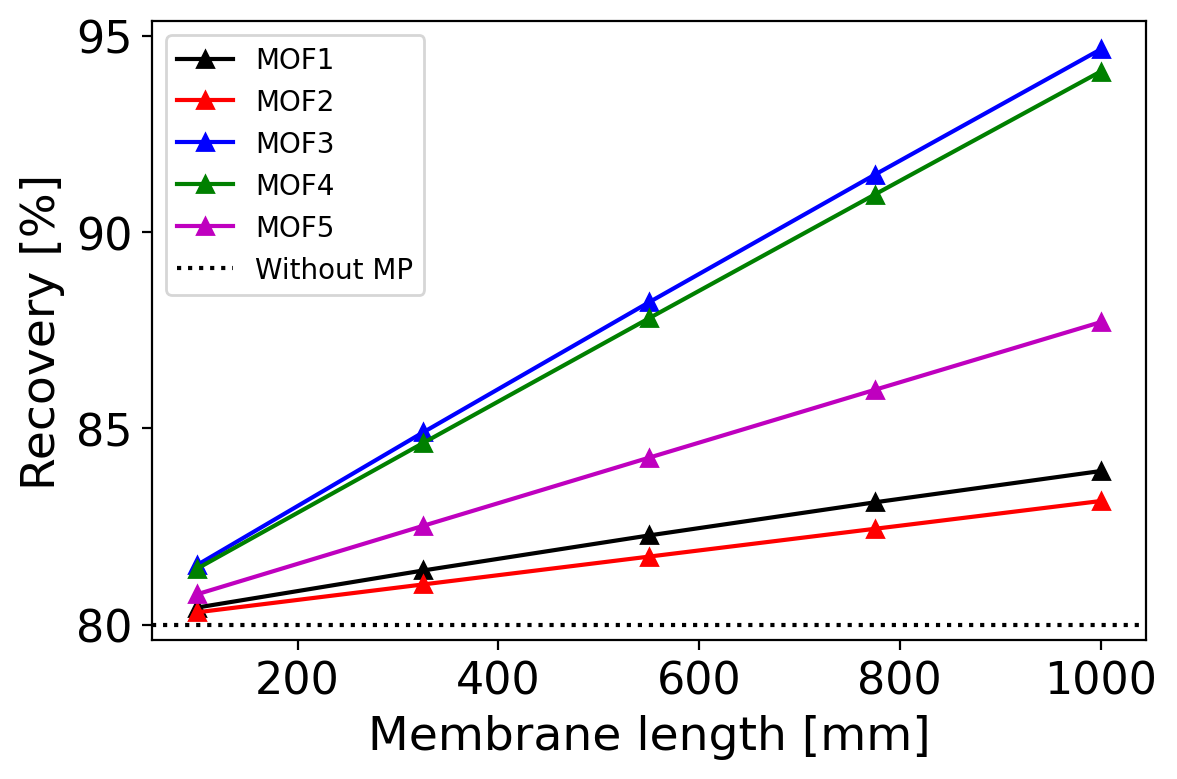

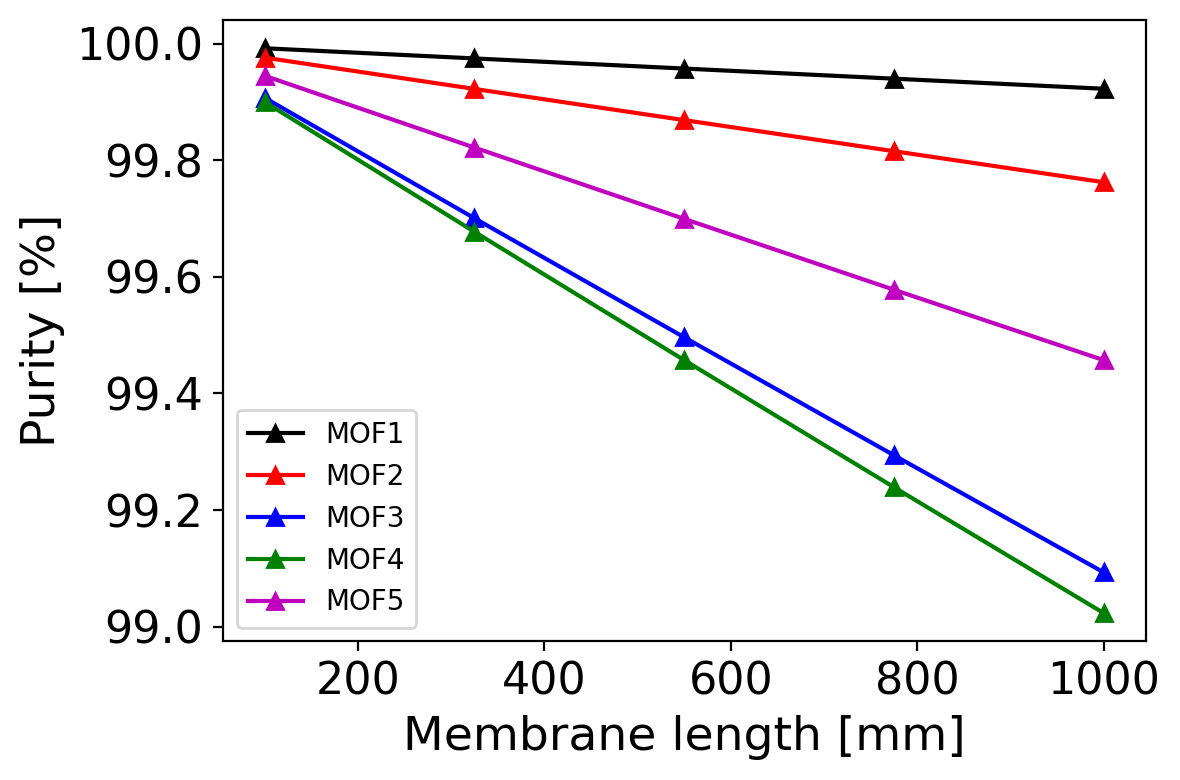

In [17]:
withoutMem = MyStreams.Elements("401").ElementS("Output").ElementS("RES_MASSFLOW").Value

c_list = ['k', 'r', 'b', 'g', 'm']
fig, ax1= plt.subplots(dpi=200, figsize=(6,4))
for ii in range(5):
    target = np.array(H2_prod[ii*len(ll_list):(ii+1)*len(ll_list)])
    ReH2 = target[:,-2]*target[:,-1]/16.0020554400001*100
    print((target[:,5])/(target[:,0]*target[:,1])*100)

    line2 = ax1.plot(np.array(ll_list), ReH2, marker='^', c=c_list[ii],
            label=f'MOF{ii+1}', linestyle='-')
    
    ax1.set_ylabel('Recovery [%]')
plt.axhline(withoutMem/16.0020554400001*100, c='k', linestyle=':',
            label = 'Without MP')
ax1.set_xlabel('Membrane length [mm]')
plt.legend()
plt.tight_layout()
plt.show()

fig, ax1= plt.subplots(dpi=200, figsize=(6,4))
for ii in range(5):
    target = np.array(H2_prod[ii*len(ll_list):(ii+1)*len(ll_list)])
    PuH2 = target[:,-1]*100

    line2 = ax1.plot(np.array(ll_list), PuH2, marker='^', c=c_list[ii],
            label=f'MOF{ii+1}', linestyle='-')
    
    ax1.set_ylabel('Purity [%]')
ax1.set_xlabel('Membrane length [mm]')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
## 결과 저장
for ii, _ll in enumerate(ll_list):
    _names = ['Ff_in', 'x_H2', 'x_N2', 'Fr_H2', 'Fr_N2', 'Fp_H2', 'Fp_N2', 'H2_prod', 'H2_purity']
    col_name = [_name + f'_L({int(_ll)})' for _name in _names]
    
    data_save[col_name] = np.array(H2_prod[ii::5])

In [24]:
data_save.to_csv('AspenMem_results.csv')